Number of images over the internet is increasing at exponential rate with the advancement of internet and availability of camera to the large proportion of population. Use of image processing software like Adobe Photoshop and Gnu Gimp can easily make forgery photo in which another image is copy pasted on original iamge .Doctored images are major concern for internet companies. These images are prime source of fake news and which are often used for mob incitement . With advancement of photo and video editing softwares it is becoming very hard for a normal human being to differentiate between a real image and a forged image we need forensic experts to do it . So we will try to build a network that will tell us which image is real and which is forged plus it will show us region of the image where some new image is copied and pasted .

### BUSINESS OBJECTIVE AND CONSTRAINT 

- There is no latency requirement as such because we don't need instant results from our model but us it should not take lot of time as well to detect forgery region and whether image is real or fake

### EXPLORATORY DATA ANALYSIS AND DATA PREPROCESSING 

In [1]:
#Importing necessary libraries
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pickle as pkl
from keras.utils.vis_utils import plot_model
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from PIL import Image, ImageChops, ImageEnhance
from sklearn.utils import shuffle
import tensorflow as tf

I downloaded data from this kaggle link https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset in which we have three files <br>
- Tp - This folder contain fake image 
- CASIA 2 Groundtruth - This folder contain fake image mask 
- Au - This folder contain real images

#### Analysis on fake images 

In [2]:
fake_image_data={'image_path':[],'label':[],'image_id':[]}

In [3]:
fake_image_path='/Users/trishitanmay/Projects/automaticforgerydetection1-main/Tp'
for img in os.listdir(fake_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=fake_image_path+"/"+str(img)
      fake_image_data['image_path'].append(temp_path)
      fake_image_data['label'].append('fake')
      fake_image_data['image_id'].append(img[:-4])
    
    

In [4]:
fake_image_data=pd.DataFrame(fake_image_data)
fake_image_data.head()

,image_path,label,image_id
0,/Users/trishitanmay/Projects/automaticforgeryd...,fake,Tp_D_NRN_M_N_nat00014_nat00028_11038
1,/Users/trishitanmay/Projects/automaticforgeryd...,fake,Tp_D_NNN_S_N_ani10200_ani10199_12409
2,/Users/trishitanmay/Projects/automaticforgeryd...,fake,Tp_D_NRN_S_N_nat10139_ani00005_11950
3,/Users/trishitanmay/Projects/automaticforgeryd...,fake,Tp_D_CRN_S_N_sec00071_art00028_11281
4,/Users/trishitanmay/Projects/automaticforgeryd...,fake,Tp_S_NNN_S_N_art00022_art00022_20083


In [5]:
print("Number of fake images are {}".format(fake_image_data.shape[0]))

Number of fake images are 2064


#### Analysis on pristine images

In [6]:
real_image_data={'image_path':[],'label':[],'image_id':[]}

In [7]:
real_image_path='/Users/trishitanmay/Projects/automaticforgerydetection1-main/Au'
for img in os.listdir(real_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=real_image_path+"/"+str(img)
      real_image_data['image_path'].append(temp_path)
      real_image_data['label'].append('real')
      real_image_data['image_id'].append(img[:-4])
    
    

In [8]:
real_image_data=pd.DataFrame(real_image_data)
real_image_data.head()

,image_path,label,image_id
0,/Users/trishitanmay/Projects/automaticforgeryd...,real,Au_pla_30535
1,/Users/trishitanmay/Projects/automaticforgeryd...,real,Au_art_30063
2,/Users/trishitanmay/Projects/automaticforgeryd...,real,Au_pla_30253
3,/Users/trishitanmay/Projects/automaticforgeryd...,real,Au_pla_20040
4,/Users/trishitanmay/Projects/automaticforgeryd...,real,Au_nat_10105


In [9]:
print("Number of real images are {}".format(real_image_data.shape[0]))

Number of real images are 7437


We can see significant difference between number of prisitine images and number of fake images which can lead to problem of imbalance dataset thus i will reduce the number of prisitne images . This technique is called as Undersampling

In [10]:
real_image_data=shuffle(real_image_data,random_state=42)
real_image_data=real_image_data.iloc[:fake_image_data.shape[0],:]

In [11]:
final_image_data=pd.concat([fake_image_data,real_image_data])

In [12]:
print("Total number of images in dataset is {}".format(final_image_data.shape[0]))

Total number of images in dataset is 4128


##### IMAGE PREPROCESSING (ERROR LEVEL ANALYSIS)

- Research Paper - https://www.researchgate.net/publication/332561655_Image_forgery_detection_using_error_level_analysis_and_deep_learning
- Reference https://www.kaggle.com/code/bchirag/casia-version2

In [13]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [14]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [15]:
X=[]
Y=[]

In [16]:
for index,rows in tqdm(final_image_data.iterrows()) :
    temp_ela_image=prepare_image(rows['image_path'])
    X.append(temp_ela_image)
    if rows['label']=='fake' :
        Y.append(0)
    else :
        Y.append(1)

0it [00:00, ?it/s]

4128it [00:28, 146.16it/s]


In [17]:
X, Y = shuffle(X, Y, random_state=42)

In [18]:
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

TRAINING AND VALIDATION SET

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)

#### CUSTOM DATAGENERATOR

In [20]:
class Dataset:
    def __init__(self, data_x,data_y):
        self.x = []
        self.y = []
        
        for img in data_x :
            self.x.append(img)
        
        for lab in data_y :
            self.y.append(lab)
            

    def __getitem__(self, i):
            
        return self.x[i],self.y[i]
        

    def __len__(self): # your model.fit_gen requires this function
        return len(self.x)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.x))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([batch[0],batch[1]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

train_dataset=Dataset(X_train,Y_train)
train_dataloader = Dataloder(train_dataset, batch_size=8,shuffle=True)

In [21]:
test_dataset=Dataset(X_val,Y_val)
test_dataloader = Dataloder(test_dataset, batch_size=8,shuffle=True)

#### MODEL BUILDING AND TRAINING

In [22]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import *

In [23]:
Input_shape=Input(shape=(128,128,3))
conv11=Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")(Input_shape)
conv12=Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(conv11)
conv13=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv12)
conv13=Dropout(0.3)(conv13)


flatten1=Flatten()(conv13)
dense1=Dense(units=16,activation="relu")(flatten1)
dense2=Dense(units=8,activation="relu")(dense1)
output=Dense(units=1, activation="sigmoid")(dense2)

model=Model(inputs=Input_shape,outputs=output)
print(model.summary())



Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 flatten (Flatten)           (None, 262144)        

In [24]:
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

##### Training the model

In [25]:
def scheduler(epoch,lr) :
  if epoch%5==0 :
    lr=0.9*lr
  
  return lr

In [26]:
#Callbacks 
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
rl=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=5)

In [27]:
history=model.fit_generator(train_dataloader,steps_per_epoch=len(train_dataloader)//8,validation_data=test_dataloader,validation_steps=len(test_dataloader)//8,epochs=30,callbacks=[lrScheduler,es,rl])

Epoch 1/30


/var/folders/t6/p3v700kj1519grzmg474x4940000gn/T/ipykernel_35101/1422361946.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_dataloader,steps_per_epoch=len(train_dataloader)//8,validation_data=test_dataloader,validation_steps=len(test_dataloader)//8,epochs=30,callbacks=[lrScheduler,es,rl])
2023-05-11 13:32:15.450300: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


51/51 [==============================] - 4s 60ms/step - loss: 0.6670 - accuracy: 0.5319 - val_loss: 0.6365 - val_accuracy: 0.4792 - lr: 9.0000e-05
Epoch 2/30
51/51 [==============================] - 3s 56ms/step - loss: 0.6129 - accuracy: 0.5147 - val_loss: 0.6114 - val_accuracy: 0.4792 - lr: 9.0000e-05
Epoch 3/30
51/51 [==============================] - 3s 56ms/step - loss: 0.5805 - accuracy: 0.5931 - val_loss: 0.5362 - val_accuracy: 0.5833 - lr: 9.0000e-05
Epoch 4/30
51/51 [==============================] - 3s 56ms/step - loss: 0.5289 - accuracy: 0.7672 - val_loss: 0.4965 - val_accuracy: 0.7812 - lr: 9.0000e-05
Epoch 5/30
51/51 [==============================] - 3s 56ms/step - loss: 0.5152 - accuracy: 0.8235 - val_loss: 0.5068 - val_accuracy: 0.8542 - lr: 9.0000e-05
Epoch 6/30
51/51 [==============================] - 3s 55ms/step - loss: 0.4945 - accuracy: 0.8284 - val_loss: 0.4708 - val_accuracy: 0.8750 - lr: 8.1000e-05
Epoch 7/30
51/51 [==============================] - 3s 55ms/ste

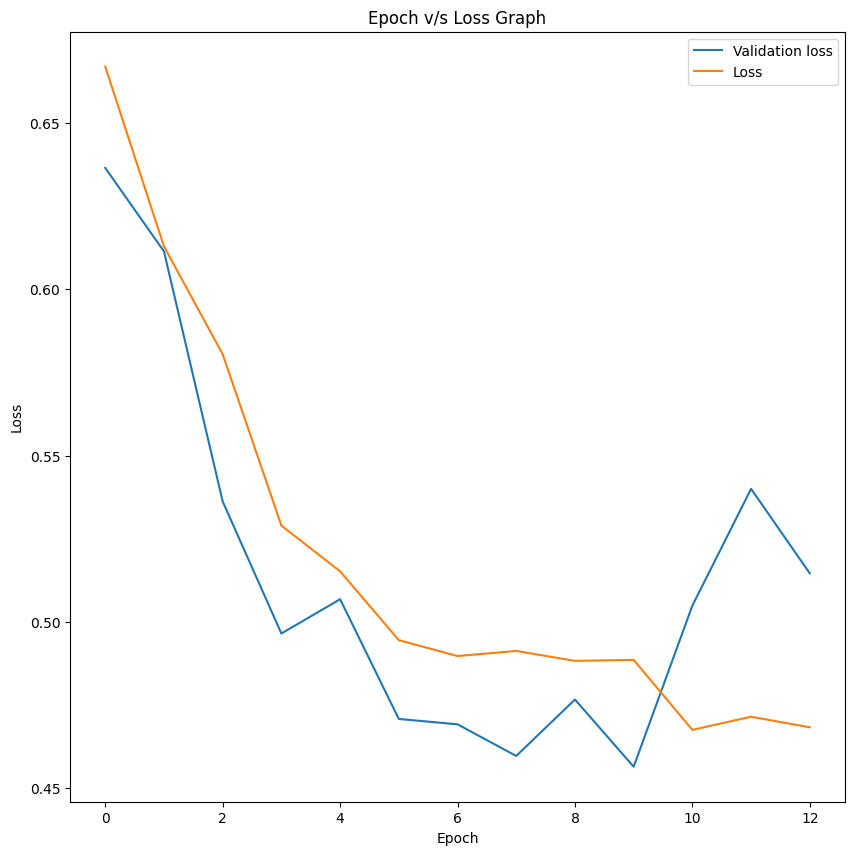

In [28]:
plt.figure(figsize=(10,10))
plt.plot(history.history['val_loss'],label='Validation loss')
plt.plot(history.history['loss'],label='Loss')
plt.title("Epoch v/s Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
ph1model_json = model.to_json()
with open("v1model.json", "w") as json_file:
    json_file.write(ph1model_json)

In [30]:
model.save_weights("v1model.h5")

##### PREDICTION

In [31]:
def predict(img_path,model) :
    pi=prepare_image(img_path)
    pi=pi.reshape(1,128,128,3)
    predict=model.predict(pi)
    return predict

In [32]:
#Prediction on 5 random images 
for i in range(1,6) :
  ran_num=np.random.randint(0,final_image_data.shape[0])
  temp_row=final_image_data.iloc[ran_num,:]
  print("="*100)
  temp_arr=plt.imread(temp_row['image_path'])
  print("Real label--- {}".format(temp_row['label']))
  temp_predict=predict(temp_row['image_path'],model)
  if temp_predict[0]>0.5 :
    temp_prediction='real'
  else:
    temp_prediction='fake'
  print("Predicted label--- {}".format(temp_prediction))


Real label--- real
1/1 [==============================] - 0s 89ms/step
Predicted label--- real
Real label--- fake
1/1 [==============================] - 0s 10ms/step
Predicted label--- fake
Real label--- fake
1/1 [==============================] - 0s 10ms/step
Predicted label--- fake
Real label--- fake
1/1 [==============================] - 0s 10ms/step
Predicted label--- fake
Real label--- real
1/1 [==============================] - 0s 10ms/step
Predicted label--- fake
